In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from pathlib import Path
import gc

In [2]:
# Cargar imágenes ligeramente corruptas
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Configurar dispositivo
import torch_directml
dml = torch_directml.device()
torch.set_default_device(dml)

# Cargar datos
data = pd.read_feather("NN_INPUT.feather")

In [4]:
data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


In [5]:
# Desechar las filas inexistentes
drop=[]
for i,r in data.iterrows():
    if not Path(f"images/{r['Path']}").exists():
        drop.append(i)
data.drop(drop,inplace=True)

In [6]:
data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


In [7]:
# Función para generar nuevas columnas
def GEN(row):
    Image,FUM,EXP,INA = row.values
    values = np.zeros(5)
    if FUM>0:
        if EXP>0:
            values[3]=1
        else:
            values[1]=1
    elif EXP>0:
        values[2]=1
    elif INA>0:
        values[0]=1
    else:
        values[4]=1
    return pd.Series(values)

In [8]:
data=pd.concat([data,data.apply(GEN,axis=1)],axis=1)
data.drop(columns=["FUM","EXP","INAC"],inplace=True)
data.columns=["Path","Inactivo","Fumarola","Explosion","FumarolaExplosion","Unknown"]

In [9]:
data.describe()

,Inactivo,Fumarola,Explosion,FumarolaExplosion,Unknown
count,21931.000000,21931.000000,21931.000000,21931.000000,21931.000000
mean,0.142492,0.406229,0.018786,0.363230,0.069263
std,0.349562,0.491139,0.135772,0.480941,0.253906
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Obtener clases de imágenes
path = Path("images/")
classdict = {}
for img in path.ls():
    try:
        classdict[img.name]=img.stem.split("_")[:3]
        classdict[img.name][0]=float(classdict[img.name][0])
    except:
        pass
def get_class(file):
    return classdict[file.name]
files = path.ls()
#test simple case
print(files[0],get_class(files[0]))

images\.ipynb_checkpoints ['.ipynb', 'checkpoints']


In [11]:
data[data["Path"]=="2000/abr/p0424002.jpg"].iloc[0]

Path                 2000/abr/p0424002.jpg
Inactivo                               0.0
Fumarola                               1.0
Explosion                              0.0
FumarolaExplosion                      0.0
Unknown                                0.0
Name: 4, dtype: object

In [12]:
def getter(l):
    def f(path):
        cpath=str(path)[7:].replace("\\","/")
        s=data[data["Path"]==cpath]
        if s.shape[0]==0:
            print("MISSING IMAGE:",path)
            return 0 if l!=5 else 1
        return s.iloc[0,l]
    return f

In [13]:
getter(2)(r"images\2002\may\p0527021.jpg")

0.0

In [14]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert=False,
                             max_rotate=90,
                             max_lighting=0.1,
                             max_zoom=1.05,
                             max_warp=0.01)
    
    dataset = fv.DataBlock(blocks    = (fv.ImageBlock, 
                                        fv.RegressionBlock,
                                        fv.RegressionBlock,
                                        fv.RegressionBlock,
                                        fv.RegressionBlock,
                                        fv.RegressionBlock),
                        n_inp     = 1,
                        get_items = fv.get_image_files,
                           
                        getters   = (lambda x: x, 
                                     getter(1), 
                                     getter(2), 
                                     getter(3), 
                                     getter(4), 
                                     getter(5)),
                           
                        splitter  = fv.RandomSplitter(1/20),
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms= tfms,
                       )
    dataset.device=dml
    return dataset.dataloaders(folder, bs=batch_size)

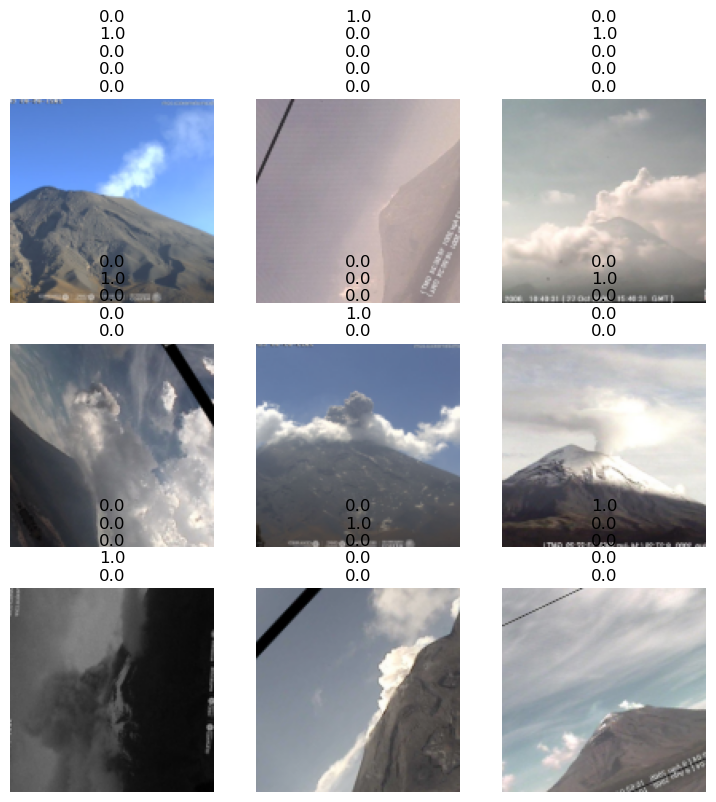

In [15]:
# Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# Cargar dataloader
dataloader = load_data("images/", 128, 64*4)
dataloader.show_batch()

In [16]:
# Definir una nueva clase para el modelo de regresión de imágenes
class ModelClass(nn.Module):
    def __init__(self, **kwargs):
        super(ModelClass, self).__init__()
        
        # Definir las capas convolucionales
        # Cada capa consta de una convolución, una normalización por lotes y una activación ReLU
        # El número de canales, tamaño del kernel, stride y padding
        # También se han agregado algunas capas de max pooling para reducir las dimensiones espaciales y aumentar el campo receptivo

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=32768, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=5)
        
        # Define una capa de dropout para prevenir el sobreajuste
        # La probabilidad de dropout se puede ajustar según tus datos y tarea
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Pasa la entrada a través de las capas convolucionales
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        print(x.shape, x.flatten(start_dim=1).shape)
        
        # Aplana la salida de la última capa convolucional
        x = torch.flatten(x, start_dim=1)
        
        # Pasa la salida aplanada a través de las capas lineales
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Regresa la salida
        return x 

In [17]:
def getMetric(i):
    def f(y, yp):
        return F.mse_loss(y[:,i], yp[:,i])
    return f

In [18]:
metrics = [getMetric(i) for i in range(5)]

In [19]:
metrics

[<function __main__.getMetric.<locals>.f(y, yp)>,
 <function __main__.getMetric.<locals>.f(y, yp)>,
 <function __main__.getMetric.<locals>.f(y, yp)>,
 <function __main__.getMetric.<locals>.f(y, yp)>,
 <function __main__.getMetric.<locals>.f(y, yp)>]

In [20]:
def combined_metric(yp, *ys):
    y = torch.stack(ys).T
    return sum([m(y, yp) for m in metrics])

In [21]:
class Normalizer(nn.Module):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m) / s

def create_learner(**kwargs):
    learn = fv.vision_learner(dataloader, ModelClass, opt_func=fv.Adam, normalize=False, **kwargs)
    learn.device = dml
    learn.model = nn.Sequential(Normalizer().to(dml), learn.model.to(dml)).to(dml)
    return learn.to_fp16()

In [22]:
gc.collect()
torch.cuda.empty_cache()
learn = create_learner(loss_func=combined_metric, n_out=5,metrics=[combined_metric])

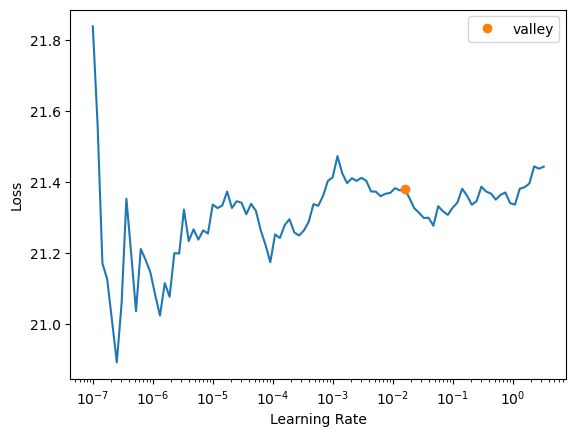

In [102]:
lr=learn.lr_find()

In [103]:
learn.fit_one_cycle(8,lr_max=1e-3,div=0.8,pct_start=0.75)

epoch,train_loss,valid_loss,combined_metric,time
0,21.423832,9.129886,9.129886,11:32
1,21.529585,9.217647,9.217647,08:36
2,21.590460,9.073098,9.073098,07:31
3,21.391376,9.208150,9.208150,07:21
4,21.533630,9.200058,9.200058,07:30
5,21.419472,9.083524,9.083524,07:41
6,21.524822,9.200393,9.200393,07:34
7,21.615871,9.058359,9.058359,07:23


In [ ]:
learn.fit_flat_cos(50,lr=1e-3)

In [104]:
learn.save("custom_model")

Path('models/custom_model.pth')

In [26]:

torch.set_default_device("cpu")

In [27]:
learn=learn.load("custom_model")

In [28]:
x,y1,y2,y3,y4,y5 = dataloader.one_batch()
print("APPLY")
m=learn.model.to("cpu")
y=torch.stack([y1,y2,y3,y4,y5]).T
yp=torch.nn.functional.softmax(m(x)).round(decimals=2)
print("y",torch.argmax(y,dim=1))
print("p",torch.argmax(yp,dim=1))

APPLY
y tensor([1, 1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 1, 4, 3, 0, 1, 1, 1, 3, 3, 1, 3,
        3, 3, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 1, 0, 2, 3, 4, 0, 3, 1, 3, 3, 4, 1,
        1, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 0, 1, 3,
        1, 4, 0, 1, 0, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 0, 1, 3, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 3, 1, 1, 3, 0, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 0, 4, 1, 1,
        1, 1, 2, 1, 3, 1, 0, 3, 0, 1, 3, 3, 1, 3, 0, 4, 1, 0, 1, 1, 1, 1, 3, 3,
        3, 0, 3, 3, 1, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 3, 1,
        3, 1, 3, 1, 0, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 0, 1, 3, 1,
        3, 3, 1, 1, 4, 1, 3, 3, 4, 1, 1, 3, 3, 1, 3, 0, 4, 1, 0, 3, 3, 1, 3, 1,
        3, 3, 0, 0, 1, 3, 1, 3, 4, 1, 0, 1, 0, 0, 1, 3, 4, 3, 3, 1, 1, 1, 4, 0,
        3, 3, 3, 3, 3, 1, 1, 4, 0, 1, 1, 2, 0, 3, 0, 0])
p TensorImage([2, 2, 3, 2, 1, 2, 2, 2, 4, 3, 2, 3, 3, 2, 3, 3, 3, 0, 3, 0, 4, 1,
             0, 3, 3, 4, 3, 0, 0, 3, 0, 0, 2, 1, 3, 2,

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de prueba
learn.device="cpu"
learn.model=learn.model.to("cpu")
learn.validate()

(#2) [8.694533348083496,8.694533348083496]

In [30]:
# Obtener predicciones del conjunto de prueba
test_preds = learn.get_preds()

In [32]:
test_preds

(tensor([[-1.0149e+00, -1.6590e+00,  5.8938e-01, -1.7362e-02,  1.2619e+00],
         [-1.2591e+00, -5.1544e-01,  1.1469e+00, -1.9047e-01,  1.5827e+00],
         [-9.0277e-01,  2.2801e-01,  1.5838e+00, -3.5846e-04, -1.2985e+00],
         ...,
         [-4.8244e-01,  6.9377e-01,  6.4151e-01,  3.9166e-01,  4.0269e-01],
         [ 1.3281e+00, -1.3849e+00,  4.7332e-01, -1.0451e+00,  6.8995e-04],
         [-6.1517e-01, -9.3761e-01, -3.5251e-01,  1.6423e-01,  1.4913e+00]]),
 (tensor([1., 0., 0.,  ..., 1., 0., 0.]),
  tensor([0., 1., 1.,  ..., 0., 1., 0.]),
  tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  tensor([0., 0., 0.,  ..., 0., 0., 1.]),
  tensor([0., 0., 0.,  ..., 0., 0., 0.])))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.11      0.12      0.12       144
           1       0.44      0.07      0.11       427
           2       0.00      0.00      0.00        19
           3       0.56      0.33      0.41       375
           4       0.04      0.12      0.05        80

    accuracy                           0.17      1045
   macro avg       0.23      0.13      0.14      1045
weighted avg       0.40      0.17      0.22      1045


Matriz de confusión:
[[ 18  23  46  17  40]
 [ 47  28 178  61 113]
 [  4   0   0   7   8]
 [ 71   4  62 124 114]
 [ 17   8  31  14  10]]


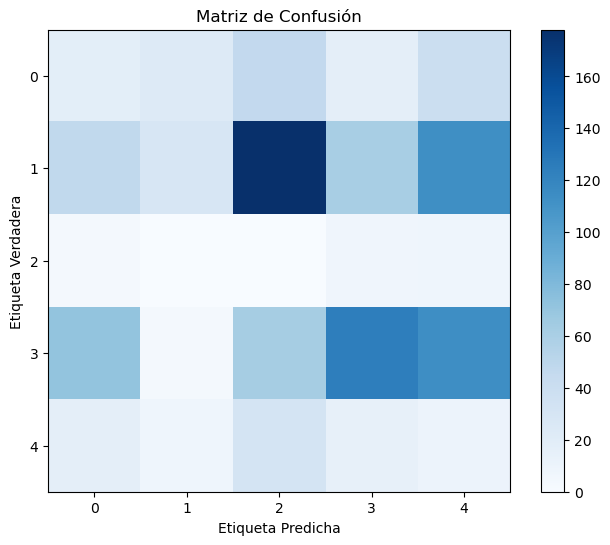

In [36]:
# Obtener etiquetas verdaderas y predicciones

true_labels = torch.stack(test_preds[1]).T.argmax(dim=1)
predicted_labels = test_preds[0].argmax(dim=1)

# Calcular métricas de evaluación
report = classification_report(true_labels.cpu(), predicted_labels.cpu())
conf_matrix = confusion_matrix(true_labels.cpu(), predicted_labels.cpu())

# Imprimir reporte de clasificación y matriz de confusión
print("Reporte de clasificación:")
print(report)
print("\nMatriz de confusión:")
print(conf_matrix)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()
